In [1]:
# this notebook will use NYC 140 years of daily data of "PRCP", "SNOW", "SNWD", "TMAX", "TMIN" to predict "PRCP"
# Gussian processe will be used to model the residual and use this as uncertainty quantification model
# gussian processes will be used as regression to model the daya


In [2]:
pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 10.4 MB/s eta 0:00:00


In [3]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00


In [4]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import gpytorch
import optuna
import gdown
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# data preprocessing

In [6]:


# URL to download the file (make sure to replace with the actual shareable link format)
url = 'https://drive.google.com/uc?id=1W-0xrfUFesnz8zOTn0ZbM-7AXhT202j9'
output = 'NYC_Central_Park_weather_1869-2022.csv'

# Download the file
gdown.download(url, output, quiet=False)

# Load the CSV file into a Pandas DataFrame
weather_df = pd.read_csv(output)

# Check the first few rows of the dataset
print(weather_df.head())


Downloading...
From: https://drive.google.com/uc?id=1W-0xrfUFesnz8zOTn0ZbM-7AXhT202j9
To: /content/NYC_Central_Park_weather_1869-2022.csv
100%|██████████| 1.33M/1.33M [00:00<00:00, 40.9MB/s]

         DATE  PRCP  SNOW  SNWD  TMIN  TMAX
0  1869-01-01  0.75   9.0   NaN  19.0  29.0
1  1869-01-02  0.03   0.0   NaN  21.0  27.0
2  1869-01-03  0.00   0.0   NaN  27.0  35.0
3  1869-01-04  0.18   0.0   NaN  34.0  37.0
4  1869-01-05  0.05   0.0   NaN  37.0  43.0


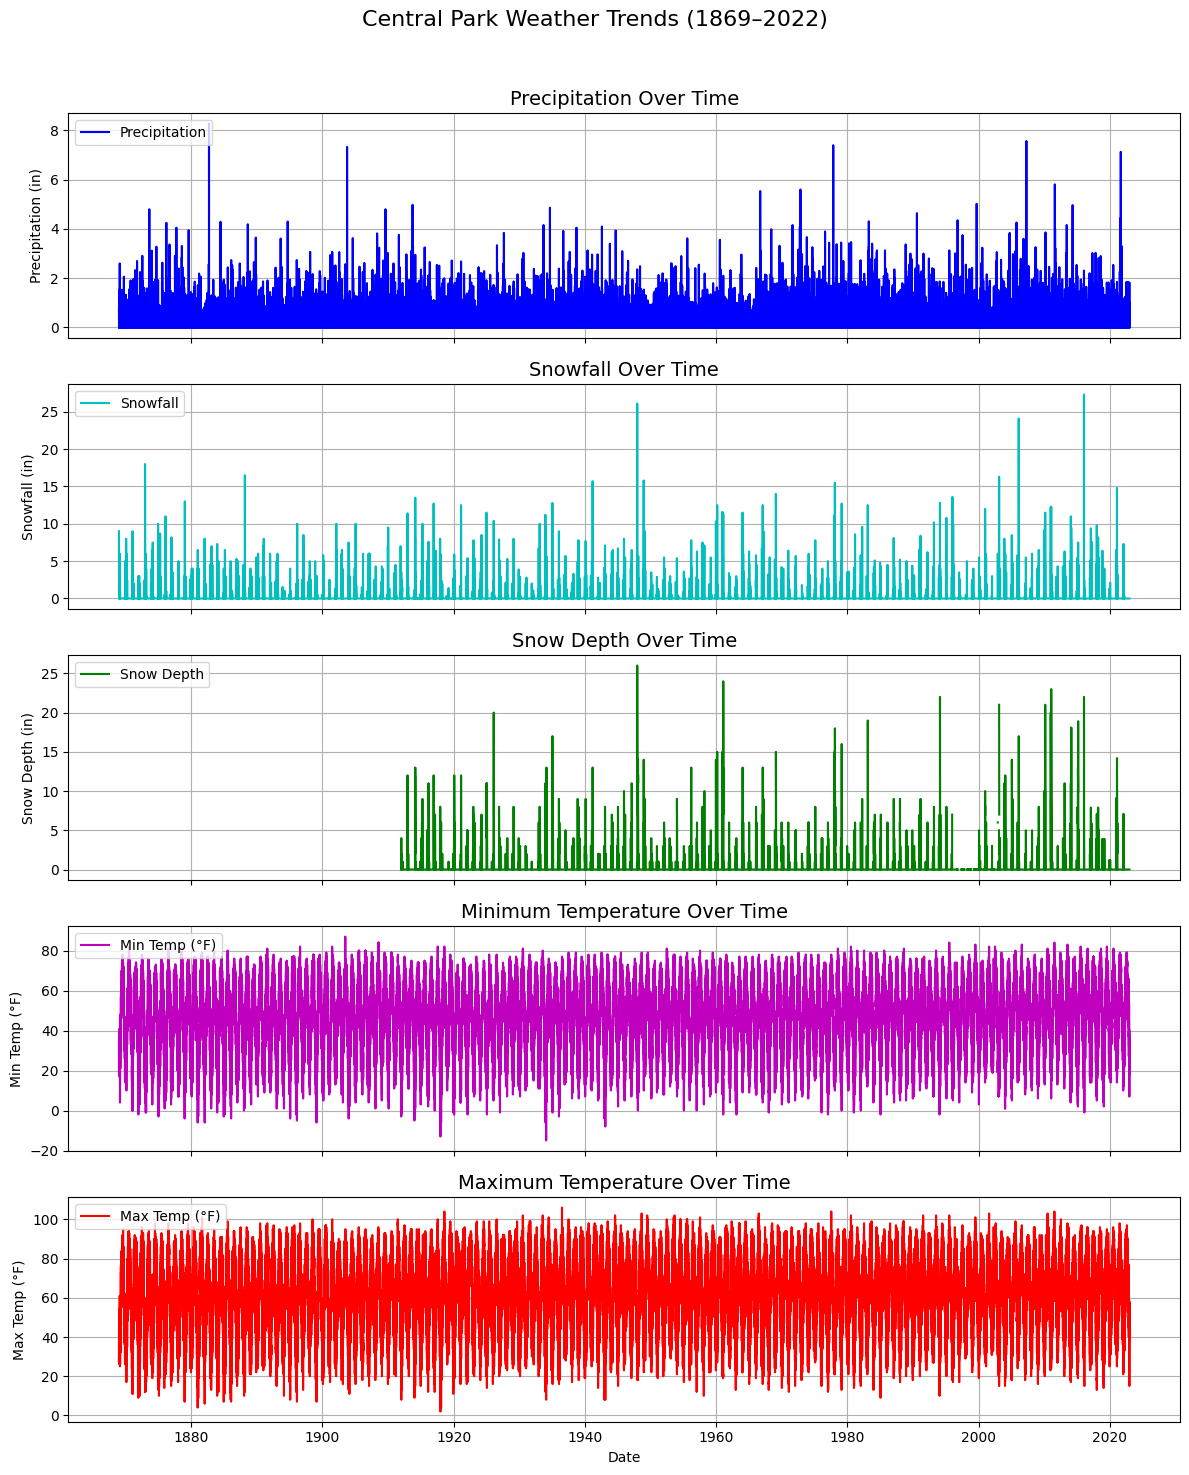

In [7]:


# Convert 'DATE' column to datetime format and set it as the index
weather_df["DATE"] = pd.to_datetime(weather_df["DATE"])
weather_df.set_index("DATE", inplace=True)

# Ensure data is ordered chronologically
weather_df.sort_index(inplace=True)

# Create a figure with five subplots for weather variables
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True)
fig.suptitle("Central Park Weather Trends (1869–2022)", fontsize=16)

# Plot Precipitation
axes[0].plot(weather_df.index, weather_df['PRCP'], color='b', label='Precipitation')
axes[0].set_ylabel("Precipitation (in)")
axes[0].grid(True)
axes[0].set_title("Precipitation Over Time", fontsize=14)
axes[0].legend(loc='upper left')

# Plot Snowfall
axes[1].plot(weather_df.index, weather_df['SNOW'], color='c', label='Snowfall')
axes[1].set_ylabel("Snowfall (in)")
axes[1].grid(True)
axes[1].set_title("Snowfall Over Time", fontsize=14)
axes[1].legend(loc='upper left')

# Plot Snow Depth
axes[2].plot(weather_df.index, weather_df['SNWD'], color='g', label='Snow Depth')
axes[2].set_ylabel("Snow Depth (in)")
axes[2].grid(True)
axes[2].set_title("Snow Depth Over Time", fontsize=14)
axes[2].legend(loc='upper left')

# Plot Minimum Temperature
axes[3].plot(weather_df.index, weather_df['TMIN'], color='m', label='Min Temp (°F)')
axes[3].set_ylabel("Min Temp (°F)")
axes[3].grid(True)
axes[3].set_title("Minimum Temperature Over Time", fontsize=14)
axes[3].legend(loc='upper left')

# Plot Maximum Temperature
axes[4].plot(weather_df.index, weather_df['TMAX'], color='r', label='Max Temp (°F)')
axes[4].set_ylabel("Max Temp (°F)")
axes[4].set_xlabel("Date")
axes[4].grid(True)
axes[4].set_title("Maximum Temperature Over Time", fontsize=14)
axes[4].legend(loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
output_path = r'C:\Users\Omid Emamjomehzadeh\Desktop\problastic time series project\Figures\Central_Park_weather_timeseries.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


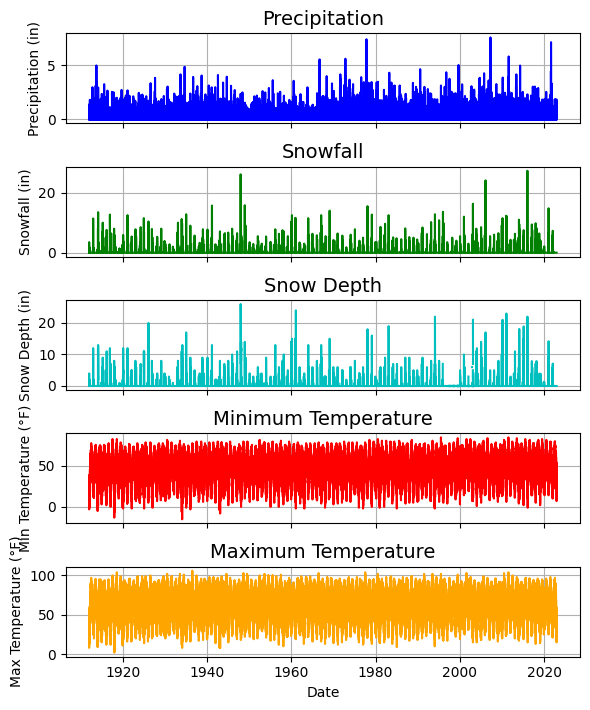

In [8]:
# Filter data for years after 1912
weather_df_post_1912 = weather_df[weather_df.index.year >= 1912]

# Create a figure with five subplots (1 for each variable)
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6,7.5 ), sharex=True)
#fig.suptitle("Weather Variables in Central Park (1912–2022)", fontsize=16)

# Plot Precipitation
axes[0].plot(weather_df_post_1912.index, weather_df_post_1912['PRCP'], color='b', label='Precipitation')
axes[0].set_ylabel("Precipitation (in)")
axes[0].grid(True)
axes[0].set_title("Precipitation", fontsize=14)

# Plot Snowfall
axes[1].plot(weather_df_post_1912.index, weather_df_post_1912['SNOW'], color='g', label='Snowfall')
axes[1].set_ylabel("Snowfall (in)")
axes[1].grid(True)
axes[1].set_title("Snowfall", fontsize=14)

# Plot Snow Depth
axes[2].plot(weather_df_post_1912.index, weather_df_post_1912['SNWD'], color='c', label='Snow Depth')
axes[2].set_ylabel("Snow Depth (in)")
axes[2].grid(True)
axes[2].set_title("Snow Depth", fontsize=14)

# Plot Minimum Temperature
axes[3].plot(weather_df_post_1912.index, weather_df_post_1912['TMIN'], color='r', label='Min Temp')
axes[3].set_ylabel("Min Temperature (°F)")
axes[3].grid(True)
axes[3].set_title("Minimum Temperature", fontsize=14)

# Plot Maximum Temperature
axes[4].plot(weather_df_post_1912.index, weather_df_post_1912['TMAX'], color='orange', label='Max Temp')
axes[4].set_ylabel("Max Temperature (°F)")
axes[4].set_xlabel("Date")
axes[4].grid(True)
axes[4].set_title("Maximum Temperature", fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
output_path = r'C:\Users\Omid Emamjomehzadeh\Desktop\problastic time series project\Figures\Weather_Variables_Post_1912.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


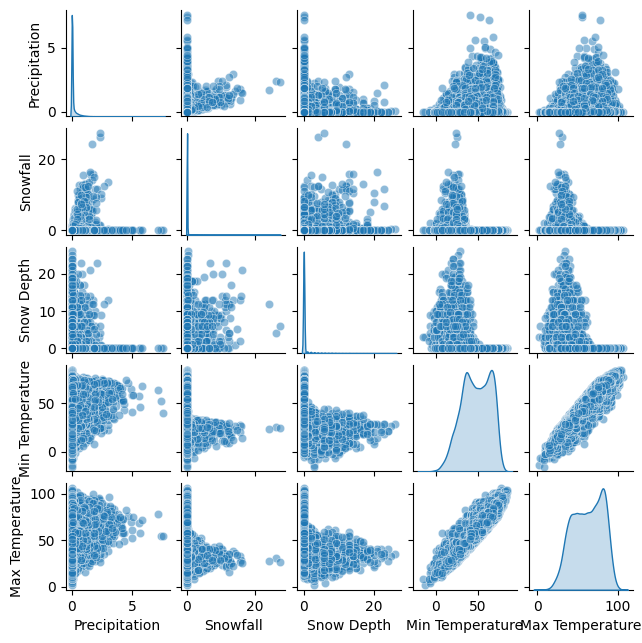

In [9]:


columns_to_plot = ['PRCP', 'SNOW', 'SNWD', 'TMIN', 'TMAX']

# Rename columns for better readability
weather_data_filtered = weather_df_post_1912[columns_to_plot]
weather_data_filtered = weather_data_filtered.rename(columns={
    'PRCP': 'Precipitation',
    'SNOW': 'Snowfall',
    'SNWD': 'Snow Depth',
    'TMIN': 'Min Temperature',
    'TMAX': 'Max Temperature'
})

# Create a scatter plot matrix with KDE marginal distributions
pairplot = sns.pairplot(
    weather_data_filtered,
    diag_kind="kde",  # KDE for marginal distributions
    plot_kws={"alpha": 0.5},  # transparency
    diag_kws={"fill": True},
    corner=False,  # Show all pairs
    height=1.3
)

# Adjust font sizespairplot.fig.suptitle("Scatter Plots and Marginal PDFs of Weather Variables (1912–2022)",
#                      y=1.02, fontsize=10)  # Smaller title font
for ax in pairplot.axes.flat:  # Adjust axis labels font size
    if ax:
        ax.set_xlabel(ax.get_xlabel(), fontsize=10)
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)

# Save the figure
output_path = r'C:\Users\Omid Emamjomehzadeh\Desktop\problastic time series project\Figures\Scatter_Marginal_PDFs_Small.png'
pairplot.savefig(output_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [10]:
# Add additional time-based features for analysis
weather_df_post_1912["day_of_year"] = weather_df_post_1912.index.dayofyear
weather_df_post_1912["month"] = weather_df_post_1912.index.month
weather_df_post_1912["year"] = weather_df_post_1912.index.year

# Derive the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3

weather_df_post_1912["season"] = weather_df_post_1912["month"].apply(get_season)

# Ensure data is ordered chronologically
weather_df_post_1912.sort_index(inplace=True)
weather_df_post_1912

<ipython-input-10-5fa3d991f78d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df_post_1912["day_of_year"] = weather_df_post_1912.index.dayofyear
<ipython-input-10-5fa3d991f78d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df_post_1912["month"] = weather_df_post_1912.index.month
<ipython-input-10-5fa3d991f78d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,PRCP,SNOW,SNWD,TMIN,TMAX,day_of_year,month,year,season
DATE,,,,,,,,,
1912-01-01,0.00,0.0,0.0,30.0,38.0,1,1,1912,4
1912-01-02,0.20,0.3,0.0,25.0,37.0,2,1,1912,4
1912-01-03,0.02,0.2,0.0,28.0,36.0,3,1,1912,4
1912-01-04,0.00,0.0,0.0,22.0,32.0,4,1,1912,4
1912-01-05,0.01,0.1,0.0,10.0,29.0,5,1,1912,4
...,...,...,...,...,...,...,...,...,...
2022-12-25,0.00,0.0,0.0,14.0,28.0,359,12,2022,4
2022-12-26,0.00,0.0,0.0,18.0,29.0,360,12,2022,4
2022-12-27,0.00,0.0,0.0,29.0,35.0,361,12,2022,4


In [11]:

# Define the list of features to handle missing values for
features = ["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]

# Iterate over each feature and fill NaN values with the mean of the column
for feature in features:
    weather_df_post_1912[feature] = weather_df_post_1912[feature].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")
    weather_df_post_1912[f"{feature}_rolling_mean"] = weather_df_post_1912[feature].rolling(window=7).mean()
    # Replace NaN values in the rolling mean with the original feature's values, only if the rolling mean is NaN
    weather_df_post_1912.loc[weather_df_post_1912[f"{feature}_rolling_mean"].isna(), f"{feature}_rolling_mean"] = weather_df_post_1912[feature]

weather_df_post_1912 = weather_df_post_1912.reset_index()
weather_df_post_1912

<ipython-input-11-8174f9635c13>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_df_post_1912[feature] = weather_df_post_1912[feature].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")
<ipython-input-11-8174f9635c13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df_post_1912[feature] = weather_df_post_1912[feature].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")
<ipython-input-11-8174f9635c13>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,DATE,PRCP,SNOW,SNWD,TMIN,TMAX,day_of_year,month,year,season,PRCP_rolling_mean,SNOW_rolling_mean,SNWD_rolling_mean,TMAX_rolling_mean,TMIN_rolling_mean
0,1912-01-01,0.00,0.0,0.0,30.0,38.0,1,1,1912,4,0.000000,0.0,0.0,38.000000,30.000000
1,1912-01-02,0.20,0.3,0.0,25.0,37.0,2,1,1912,4,0.200000,0.3,0.0,37.000000,25.000000
2,1912-01-03,0.02,0.2,0.0,28.0,36.0,3,1,1912,4,0.020000,0.2,0.0,36.000000,28.000000
3,1912-01-04,0.00,0.0,0.0,22.0,32.0,4,1,1912,4,0.000000,0.0,0.0,32.000000,22.000000
4,1912-01-05,0.01,0.1,0.0,10.0,29.0,5,1,1912,4,0.010000,0.1,0.0,29.000000,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40536,2022-12-25,0.00,0.0,0.0,14.0,28.0,359,12,2022,4,0.294286,0.0,0.0,38.000000,21.714286
40537,2022-12-26,0.00,0.0,0.0,18.0,29.0,360,12,2022,4,0.294286,0.0,0.0,36.571429,19.857143
40538,2022-12-27,0.00,0.0,0.0,29.0,35.0,361,12,2022,4,0.294286,0.0,0.0,36.000000,19.714286
40539,2022-12-28,0.00,0.0,0.0,33.0,47.0,362,12,2022,4,0.294286,0.0,0.0,37.000000,20.571429


In [12]:
features = ['PRCP', 'SNOW', 'SNWD', 'TMIN', 'TMAX', 'day_of_year', 'month',
            'year', 'season', 'PRCP_rolling_mean', 'SNOW_rolling_mean',
            'SNWD_rolling_mean', 'TMAX_rolling_mean', 'TMIN_rolling_mean']

# Standardize the features
scaler = StandardScaler()

scaled_data = scaler.fit_transform(weather_df_post_1912[features])

In [13]:
# Step 4: Create Sequences for Time Series Modeling

def create_sequences(data, seq_length):
    """
    Creates input-output sequences for time series data.

    Parameters:
    - data: The scaled feature data as a NumPy array.
    - seq_length: The length of each input sequence.

    Returns:
    - X: Input sequences as a NumPy array.
    - y: Corresponding target values as a NumPy array.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Extract a sequence of length 'seq_length' for input
        X.append(data[i : (i + seq_length)])
        # The target is the data point immediately after the input sequence
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define the sequence length (e.g., 30 days)
seq_length = 30

# Create input-output sequences using the defined sequence length
X, y = create_sequences(scaled_data, seq_length)

In [14]:
#Step 5: Split Data into Training and Validation Sets

# Determine the size of the training set (80% of the data)
train_size = int(len(X) * 0.8)

# Split the input sequences into training and validation sets
X_train, X_val = X[:train_size], X[train_size:]

# Split the target values into training and validation sets
y_train, y_val = y[:train_size], y[train_size:]


In [15]:
#Define a Custom Dataset Class for PyTorch

class WeatherDataset(Dataset):
    """
    A custom Dataset class for weather data sequences.

    Attributes:
    - X: Input sequences as torch.FloatTensor.
    - y: Target values as torch.FloatTensor.
    """
    def __init__(self, X, y):
        # Convert input sequences to torch.FloatTensor
        self.X = torch.FloatTensor(X)
        # Convert target values to torch.FloatTensor
        self.y = torch.FloatTensor(y)

    def __len__(self):
        # Return the total number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # Retrieve the input sequence and target value at the specified index
        return self.X[idx], self.y[idx]

# Initialize the training and validation datasets
train_dataset = WeatherDataset(X_train, y_train)
val_dataset = WeatherDataset(X_val, y_val)

# Create DataLoader objects for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
#Define the LSTM Model Architecture

class WeatherLSTM(nn.Module):
    """
    A Long Short-Term Memory (LSTM) network for weather prediction.

    Attributes:
    - lstm: An LSTM layer.
    - fc: A fully connected layer to produce the final output.
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super().__init__()
        # Initialize the LSTM layer with specified parameters
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True
        )
        # Initialize the fully connected layer
        self.fc = nn.Linear(hidden_size * 2, input_size)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Parameters:
        - x: Input tensor of shape (batch_size, seq_length, input_size).

        Returns:
        - Output tensor after passing through LSTM and fully connected layer.
        """
        # Pass the input through the LSTM layer
        lstm_out, _ = self.lstm(x)
        # Pass the output of the last time step through the fully connected layer
        return self.fc(lstm_out[:, -1, :])

In [17]:
# Step 8: Initialize Model, Loss Function, and Optimizer

# Determine the device to run the model on (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the WeatherLSTM model with input size equal to the number of features
model = WeatherLSTM(len(features), 64, 2).to(device)

# Define the Mean Squared Error loss function
criterion = nn.MSELoss()

# Initialize the Adam optimizer with a learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the number of training epochs
num_epochs = 30

# Initialize a learning rate scheduler that reduces LR on plateau
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)

In [18]:
# Initialize variables to track the best validation loss and patience
best_val_loss = float("inf")
patience = 5
patience_counter = 0

# Start the training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    train_loss = 0
    # Iterate over batches in the training DataLoader
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Move data to the appropriate device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients from the previous step
        optimizer.zero_grad()

        # Forward pass: compute model predictions
        output = model(X_batch)

        # Compute the loss between predictions and true values
        loss = criterion(output, y_batch)

        # Backward pass: compute gradients
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update model parameters
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Compute the average training loss for the epoch
    train_loss /= len(train_loader)

    # Set the model to evaluation mode
    model.eval()
    val_loss = 0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over batches in the validation DataLoader
        for X_batch, y_batch in val_loader:
            # Move data to the appropriate device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass: compute model predictions
            output = model(X_batch)

            # Compute the loss between predictions and true values
            val_loss += criterion(output, y_batch).item()

    # Compute the average validation loss for the epoch
    val_loss /= len(val_loader)

    # Step the scheduler based on the validation loss
    scheduler.step(val_loss)

    # Print the training and validation loss for the current epoch
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # Check if the current validation loss is the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if improvement
    else:
        patience_counter += 1  # Increment patience counter if no improvement
        # Trigger early stopping if patience is exceeded
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
# Output the Best Validation Loss

# Print the best validation Mean Squared Error achieved during training
print(f"Best validation MSE: {best_val_loss:.6f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1, Train Loss: 0.282802, Val Loss: 0.306484
Epoch 2, Train Loss: 0.198990, Val Loss: 0.281775
Epoch 3, Train Loss: 0.191328, Val Loss: 0.271628
Epoch 4, Train Loss: 0.187545, Val Loss: 0.267711
Epoch 5, Train Loss: 0.184690, Val Loss: 0.262558
Epoch 6, Train Loss: 0.182128, Val Loss: 0.261407
Epoch 7, Train Loss: 0.180695, Val Loss: 0.258554
Epoch 8, Train Loss: 0.179003, Val Loss: 0.258085
Epoch 9, Train Loss: 0.178015, Val Loss: 0.257013
Epoch 10, Train Loss: 0.176642, Val Loss: 0.255388
Epoch 11, Train Loss: 0.175957, Val Loss: 0.252787
Epoch 12, Train Loss: 0.175175, Val Loss: 0.252181
Epoch 13, Train Loss: 0.174445, Val Loss: 0.255775
Epoch 14, Train Loss: 0.173538, Val Loss: 0.254143
Epoch 15, Train Loss: 0.173352, Val Loss: 0.252442
Epoch 16, Train Loss: 0.173120, Val Loss: 0.254513
Epoch 17, Train Loss: 0.172377, Val Loss: 0.253056
Early stopping triggered
Best validation MSE: 0.252181


In [19]:
# Step 11: Make Predictions on the Validation Set

# Set the model to evaluation mode
model.eval()
predictions, actuals = [], []

# Disable gradient computation for predictions
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        # Move data to the appropriate device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass: get predictions from the model
        output = model(X_batch)

        # Store the predictions and actual values
        predictions.append(output.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Concatenate the batches into a single array
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)


In [20]:
# Step 12: Reverse Scaling of Predictions and Targets

# Inverse transform the scaled predictions and actual values
predictions_rescaled = scaler.inverse_transform(predictions)
actuals_rescaled = scaler.inverse_transform(actuals)

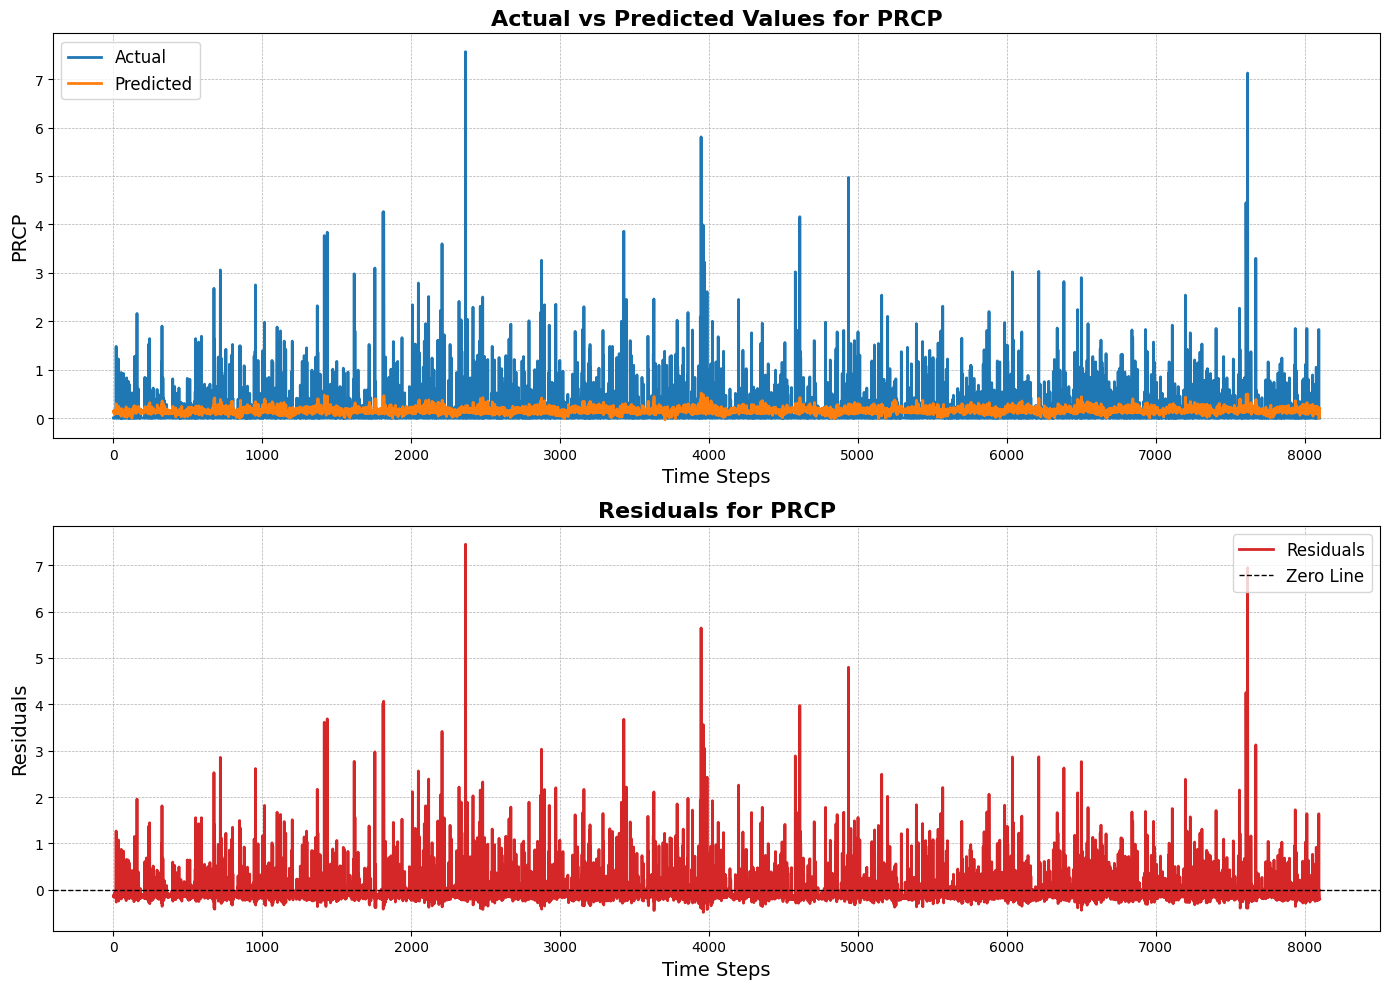

In [21]:
import matplotlib.pyplot as plt

# Step 13: Plot Actual vs Predicted Values

# Define the feature to visualize (e.g., 0 for PRCP)
feature_index = 0  # Change this to the desired feature index

# Calculate residuals
residuals = actuals_rescaled[:, feature_index] - predictions_rescaled[:, feature_index]

# Create a figure with two subplots: actual vs predicted and residuals
plt.figure(figsize=(14, 10))

# Subplot 1: Actual vs Predicted
plt.subplot(2, 1, 1)
plt.plot(actuals_rescaled[:, feature_index], label="Actual", color="#1f77b4", linewidth=2)  # Blue color
plt.plot(predictions_rescaled[:, feature_index], label="Predicted", color="#ff7f0e", linewidth=2)  # Orange color
plt.title(f"Actual vs Predicted Values for {features[feature_index]}", fontsize=16, fontweight='bold')
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel(features[feature_index], fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Subplot 2: Residuals
plt.subplot(2, 1, 2)
plt.plot(residuals, label="Residuals", color="#d62728", linewidth=2)  # Red color
plt.axhline(0, color="black", linestyle="--", linewidth=1, label="Zero Line")
plt.title(f"Residuals for {features[feature_index]}", fontsize=16, fontweight='bold')
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


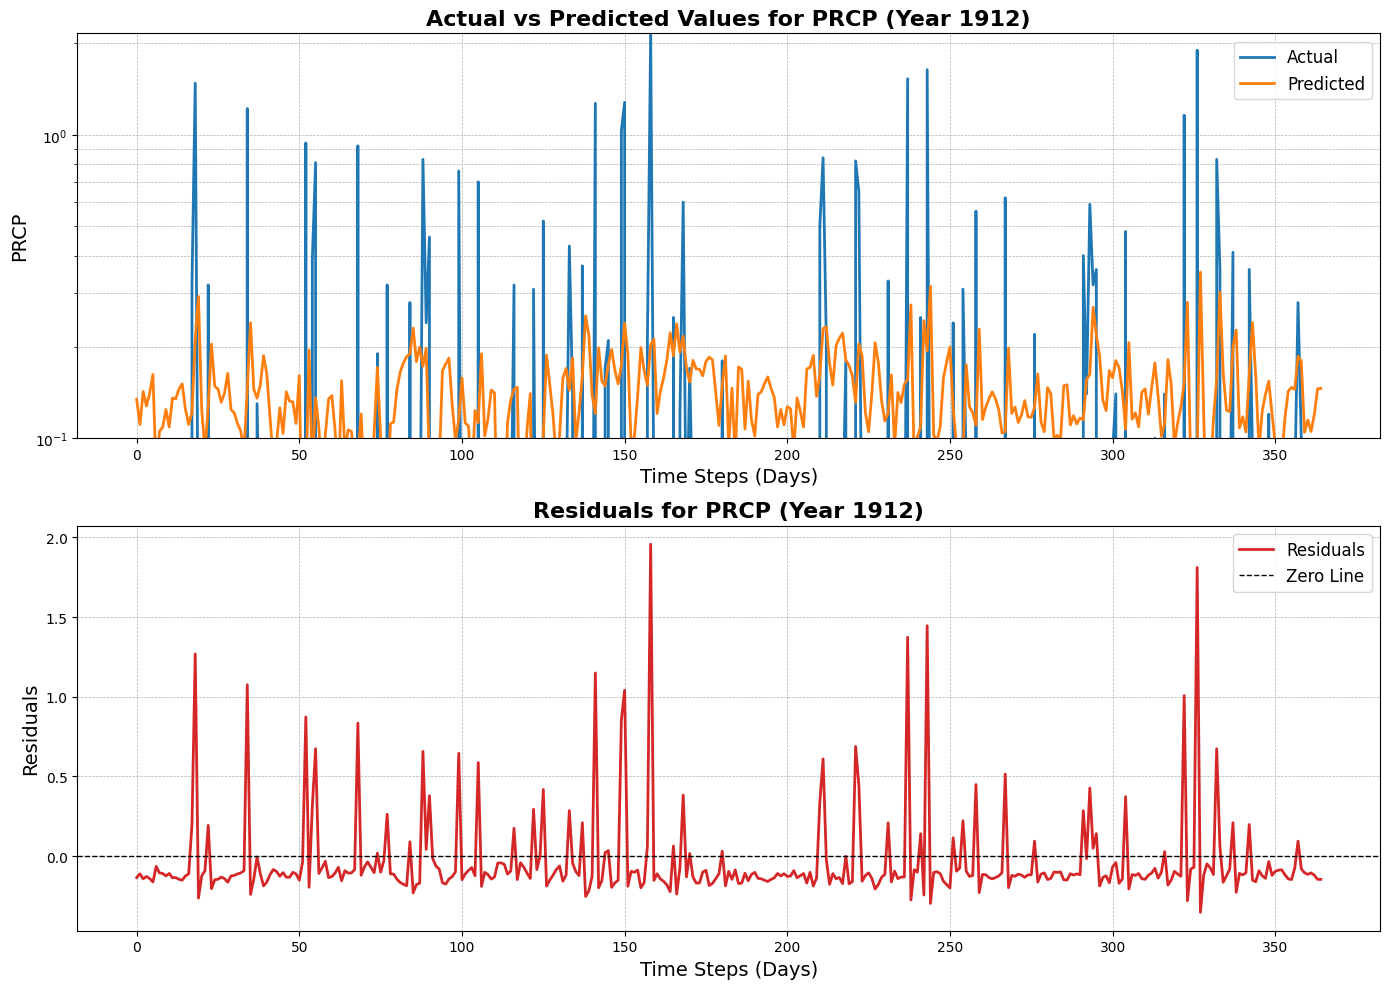

In [22]:
import matplotlib.pyplot as plt

# Define the feature to visualize (e.g., 0 for PRCP)
feature_index = 0  # Change this to the desired feature index

# Slice the first 365 values (representing the first year)
actuals_year = actuals_rescaled[:365, feature_index]
predictions_year = predictions_rescaled[:365, feature_index]

# Calculate residuals for the first year
residuals_year = actuals_year - predictions_year

# Create a figure with two subplots: actual vs predicted and residuals
plt.figure(figsize=(14, 10))

# Subplot 1: Actual vs Predicted for the first year
plt.subplot(2, 1, 1)
plt.plot(actuals_year, label="Actual", color="#1f77b4", linewidth=2)  # Blue color
plt.plot(predictions_year, label="Predicted", color="#ff7f0e", linewidth=2)  # Orange color
plt.title(f"Actual vs Predicted Values for {features[feature_index]} (Year 1912)", fontsize=16, fontweight='bold')
plt.xlabel("Time Steps (Days)", fontsize=14)
plt.ylabel(features[feature_index], fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.ylim(10**-1, max(actuals_year.max(), predictions_year.max()))

# Subplot 2: Residuals for the first year
plt.subplot(2, 1, 2)
plt.plot(residuals_year, label="Residuals", color="#d62728", linewidth=2)  # Red color
plt.axhline(0, color="black", linestyle="--", linewidth=1, label="Zero Line")
plt.title(f"Residuals for {features[feature_index]} (Year 1912)", fontsize=16, fontweight='bold')
plt.xlabel("Time Steps (Days)", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


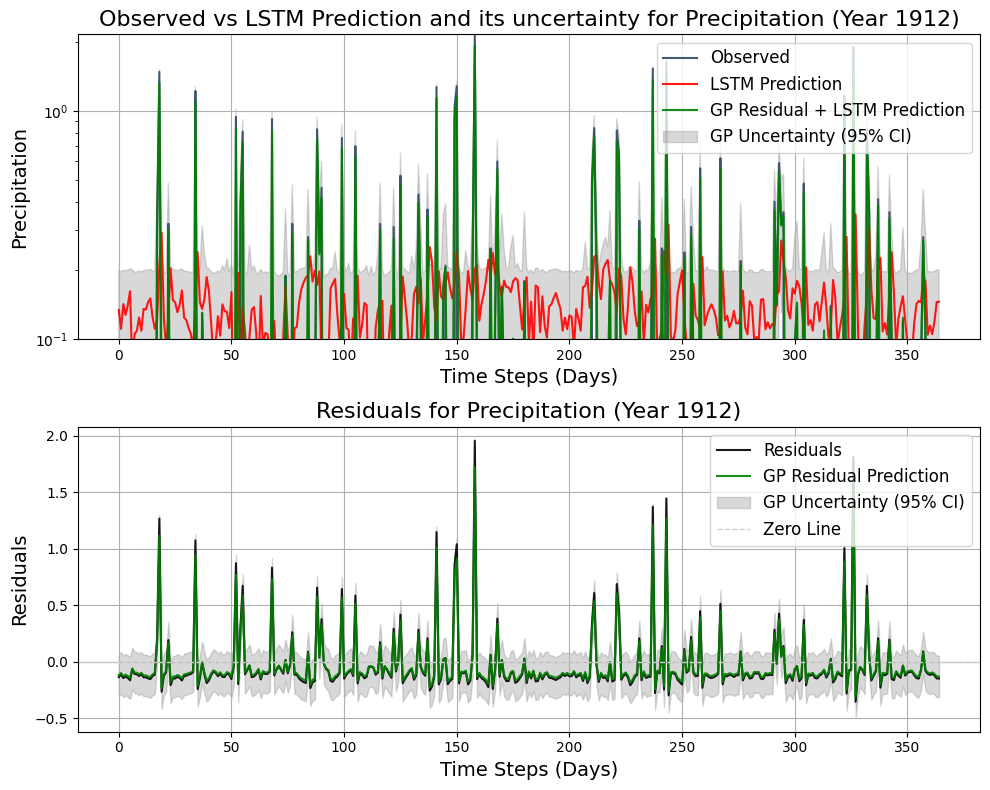

In [23]:
# Define the feature to visualize (e.g., 0 for PRCP)
feature_index = 0  # Change this to the desired feature index

# Slice the first 365 values (representing the first year)
actuals_year = actuals_rescaled[:365, feature_index]
predictions_year = predictions_rescaled[:365, feature_index]

# Calculate residuals for the first year
residuals_year = actuals_year - predictions_year

# Fit a Gaussian Process to the residuals
X = np.arange(len(residuals_year)).reshape(-1, 1)  # Time steps as input
y = residuals_year  # Residuals as target

# Define a kernel: Constant Kernel * RBF Kernel (Radial Basis Function)
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))

# Create the GaussianProcessRegressor model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Fit the GP model to the residuals
gp.fit(X, y)

# Generate predictions (mean and standard deviation) for residuals
X_pred = np.arange(len(residuals_year)).reshape(-1, 1)
y_pred, sigma = gp.predict(X_pred, return_std=True)  # Mean and std deviation of residuals

# Create a figure with two subplots: observed vs LSTM prediction and residuals with GP predictions
plt.figure(figsize=(10, 8))

# Subplot 1: Observed vs LSTM Prediction for the first year with GP prediction and uncertainty
plt.subplot(2, 1, 1)
plt.plot(actuals_year, label="Observed", color="#2E4A62", alpha=0.9)  # Darker blue for Observed
plt.plot(predictions_year, label="LSTM Prediction", color="red", alpha=0.9)  # Soft coral for LSTM Prediction

# Plot GP residual predictions
plt.plot(X_pred.flatten(), y_pred + predictions_year, label="GP Residual + LSTM Prediction", color="green", alpha=0.9)  # Mid-tone green for GP Prediction

# Plot GP uncertainty (shaded region for the uncertainty around the GP predictions)
plt.fill_between(X_pred.flatten(), (y_pred - 1.96 * sigma) + predictions_year, (y_pred + 1.96 * sigma) + predictions_year, color="gray", alpha=0.3, label='GP Uncertainty (95% CI)')  # Pastel yellow for Uncertainty

plt.title(f"Observed vs LSTM Prediction and its uncertainty for Precipitation (Year 1912)", fontsize=16)
plt.xlabel("Time Steps (Days)", fontsize=14)
plt.ylabel("Precipitation", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.yscale('log')
plt.ylim(10**-1, max(actuals_year.max(), predictions_year.max()))

# Subplot 2: Residuals for the first year with GP residual predictions and uncertainty
plt.subplot(2, 1, 2)
plt.plot(residuals_year, label="Residuals", color="black", alpha=0.9)  # Rich maroon for Residuals

# Plot GP residual predictions
plt.plot(X_pred.flatten(), y_pred, label="GP Residual Prediction", color="green", alpha=0.9)  # Mid-tone green for GP Residual Prediction

# Plot GP uncertainty (shaded region for the uncertainty around the GP residuals)
plt.fill_between(X_pred.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color="gray", alpha=0.3, label='GP Uncertainty (95% CI)')  # Pastel yellow for Uncertainty

plt.axhline(0, color="#D0D0D0", linestyle="--", linewidth=1, label="Zero Line")  # Light gray for Zero Line
plt.title(f"Residuals for Precipitation (Year 1912)", fontsize=16)
plt.xlabel("Time Steps (Days)", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()



In [24]:
# Check GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the feature to visualize (e.g., 0 for PRCP)
feature_index = 0  # Change this to the desired feature index

# Calculate residuals
residuals = actuals_rescaled[:, feature_index] - predictions_rescaled[:, feature_index]
print("Residuals calculated.")

# Convert data to PyTorch tensors and move to the GPU if available
X = torch.tensor(np.arange(len(residuals)).reshape(-1, 1), dtype=torch.float32).to(device)
y = torch.tensor(residuals, dtype=torch.float32).to(device)
print("Data converted to PyTorch tensors and moved to device.")

# Define the GP model using a RBF kernel (similar to the previous kernel)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        # Define the kernel: Constant * RBF Kernel
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        # Define the forward pass (mean and covariance)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

# Create the GP model
model = GPModel(X, y, likelihood).to(device)
print("GPModel created.")

# Set the model and likelihood to training mode
model.train()
likelihood.train()

# Define the optimizer and the loss function
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Fit the GP model
print("Fitting the Gaussian Process model...")
for i in range(100):  # 100 iterations for optimization
    optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f"Iteration {i+1}/100 - Loss: {loss.item()}")

# Make predictions
model.eval()
likelihood.eval()
with torch.no_grad():
    # Make predictions using the model
    preds = model(X)
    y_pred = preds.mean.cpu().numpy()  # Predicted mean
    sigma = preds.stddev.cpu().numpy()  # Standard deviation (for confidence interval)
    print("Predictions generated.")



Using device: cpu
Residuals calculated.
Data converted to PyTorch tensors and moved to device.
GPModel created.
Fitting the Gaussian Process model...
Iteration 1/100 - Loss: 1.1175416707992554
Iteration 11/100 - Loss: 0.7711043953895569
Iteration 21/100 - Loss: 0.5751436352729797
Iteration 31/100 - Loss: 0.5431864261627197
Iteration 41/100 - Loss: 0.5084980130195618
Iteration 51/100 - Loss: 0.49886399507522583
Iteration 61/100 - Loss: 0.4942165017127991
Iteration 71/100 - Loss: 0.49135419726371765
Iteration 81/100 - Loss: 0.491098016500473
Iteration 91/100 - Loss: 0.4904915690422058


/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Predictions generated.


In [ ]:
#Hyperparameter tuning

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 0.02)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    # Create DataLoaders with suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = WeatherLSTM(len(features), hidden_size, num_layers, dropout=dropout).to(device)

    # Define the optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Define a scheduler
    scheduler = OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=10)

    # Training loop
    num_epochs = 50
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                val_loss += criterion(output, y_batch).item()

        val_loss /= len(val_loader)

        # Step the scheduler
        scheduler.step()

        # Update best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss

    return best_val_loss

# Optuna Study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train final model with best hyperparameters
best_params = study.best_params
model = WeatherLSTM(len(features), best_params["hidden_size"], best_params["num_layers"], dropout=best_params["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"])
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)


[I 2024-12-12 21:47:28,133] A new study created in memory with name: no-name-89a13e77-748a-4047-a948-1eb9a4ea2af8
<ipython-input-25-6a8d7cbc2412>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 0.02)


I used chat GPT assistance in writing this code.